![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Decoupling: Sorting bins method
</b>
</span>

---
**Notebook version**: `1` (19 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)

</br>

# **Description**

- Calculate daily correlation between two time series.


</br>

# **Imports**

In [1]:
import importlib.metadata
from datetime import datetime
import pandas as pd
import warnings
warnings.simplefilter("ignore", UserWarning)
from diive.pkgs.analyses.decoupling import SortingBinsMethod
from diive.configs.exampledata import load_exampledata_parquet  # Example data
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.71.5


</br>

# **Load example data**

In [2]:
vpd_col = 'VPD_f'  # Vapor pressure deficit
ta_col = 'Tair_f'  # Air temperature
swin_col = 'Rg_f'  # Radiation used to detect daytime data

In [3]:
# Load 10-year dataset of half-hourly measurements
df = load_exampledata_parquet()

# Keep data between June and September
df = df.loc[(df.index.month >= 6) & (df.index.month <= 9)].copy()

# Keep daytime data (radiation > 50 W m-2) and data when air temperatures was > 5°C
daytime_locs = (df[swin_col] > 50) & (df[ta_col] > 0)  
df = df[daytime_locs].copy()

# Rename variables
rename_dict = {
    ta_col: 'air_temperature',
    vpd_col: 'vapor_pressure_deficit',
    swin_col: 'short-wave_incoming_radiation'
}
df = df.rename(columns=rename_dict, inplace=False)

# Use new column names
ta_col = 'air_temperature'
vpd_col = 'vapor_pressure_deficit'
swin_col = 'short-wave_incoming_radiation'

# Make subset
df = df[[ta_col, vpd_col, swin_col]].copy()

df

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.055 seconds). Detected time resolution of <30 * Minutes> / 30T 


,air_temperature,vapor_pressure_deficit,short-wave_incoming_radiation
TIMESTAMP_MIDDLE,,,
2013-06-01 06:45:00,0.233000,0.062000,108.790000
2013-06-01 07:15:00,0.333000,0.065000,137.107000
2013-06-01 07:45:00,0.400000,0.000000,172.567000
2013-06-01 08:15:00,1.000000,0.066000,250.213000
2013-06-01 08:45:00,1.433000,0.097000,249.253000
...,...,...,...
2022-09-30 15:15:00,3.293333,0.000000,85.807829
2022-09-30 15:45:00,3.033333,0.005826,117.456006
2022-09-30 16:15:00,3.216667,0.155508,111.234822


</br>

# **Calculate bin medians**

In [4]:
sbm = SortingBinsMethod(df=df,
                        var1_col=ta_col,
                        var2_col=swin_col,
                        var3_col=vpd_col,
                        n_bins_var1=5,
                        n_subbins_var2=10,
                        convert_to_percentiles=False)
sbm.calcbins()

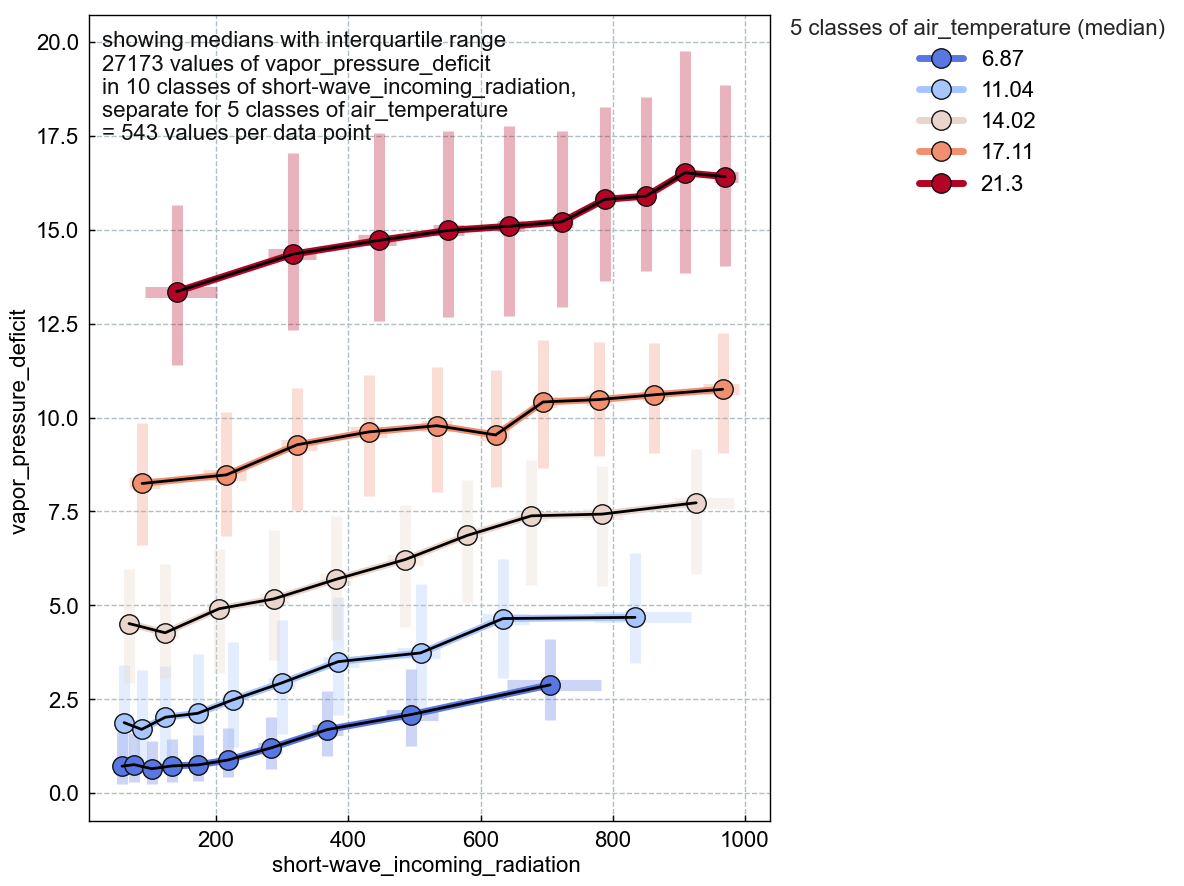

In [5]:
sbm.showplot_decoupling_sbm(marker='o', emphasize_lines=True)

Binning results (were also used to create the plot):

In [6]:
binmedians = sbm.get_binmedians()

In this example, the air temperature median is used as key in the results dictionary:

In [7]:
keys = []
for group_key, group_df in binmedians.items():
    keys.append(group_key)
print(keys, end=" ")

['6.87', '11.04', '14.02', '17.11', '21.3'] 

To access the results for the warmest class:

In [9]:
binmedians['21.3']

,group_short-wave_incoming_radiation,air_temperature,vapor_pressure_deficit,short-wave_incoming_radiation,short-wave_incoming_radiation_P25,vapor_pressure_deficit_P25,short-wave_incoming_radiation_P75,vapor_pressure_deficit_P75,xerror_neg,xerror_pos,yerror_neg,yerror_pos
0,"(50.501000000000005, 248.858]",20.433000,13.352500,140.008100,92.028000,11.403918,201.579470,15.652500,47.980100,61.571370,1.948582,2.300000
1,"(248.858, 378.989]",20.696000,14.348000,315.860000,278.933209,12.333500,350.212000,17.042000,36.926791,34.352000,2.014500,2.694000
2,"(378.989, 500.326]",20.646667,14.715000,446.342412,413.710000,12.571000,472.448000,17.567962,32.632412,26.105588,2.144000,2.852962
3,"(500.326, 601.225]",20.841500,14.978659,550.305000,528.491004,12.672000,575.119914,17.615750,21.813996,24.814914,2.306659,2.637091
4,"(601.225, 689.158]",20.823000,15.090000,642.813990,624.398051,12.694037,666.484500,17.760125,18.415940,23.670510,2.395963,2.670125
5,"(689.158, 757.765]",20.740000,15.211000,723.487000,706.059500,12.947749,739.497500,17.623500,17.427500,16.010500,2.263251,2.412500
6,"(757.765, 819.964]",20.999000,15.805980,788.087000,772.601250,13.626343,803.778156,18.255153,15.485750,15.691156,2.179637,2.449173
7,"(819.964, 880.476]",21.213000,15.894000,850.640000,835.754144,13.893000,863.295000,18.522338,14.885856,12.655000,2.001000,2.628338
8,"(880.476, 937.218]",21.467000,16.514000,909.293000,894.870000,13.850500,923.400409,19.746000,14.423000,14.107409,2.663500,3.232000
9,"(937.218, 1113.006]",21.131500,16.412815,970.088000,952.951163,14.023010,989.821500,18.843260,17.136837,19.733500,2.389805,2.430445


</br>

# **End of notebook**

In [10]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-03-22 12:11:53
